In [8]:
%pylab
%matplotlib inline

from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

def readfile(filename, n,d):
    y = np.zeros(n) # targets
    X = np.zeros((n,d)) # input matrix each row is a sample data point
    li = 0 
    with open(filename, "rb") as f:
        for line in f:
           if li>=n : 
             break;
           parts = line.split()
           y[li] = float(parts[0])
           for i in range(len(parts)): 
                if i >0 and parts[i] != '\n': 
                    fparts = parts[i].split(":")
                    X[li,int(fparts[0])-1] = float(fparts[1])
           li = li +1
    return (y,X)
def get_data_plot(stats):
    xvals = np.array([x1 for x1, y1 in stats])
    yvals = np.array([y1 for x1, y1 in stats])
    return (xvals,yvals)


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [9]:
def w_alpha(alpha,X,lambd): # check the equation 3 of (SDCA) paper
    n, d = X.shape
    w = np.zeros(d)
    for i in range(n): 
        w = w + alpha[i]*X[i,:]/(lambd*n)
    return w

def dual_obj(w, alpha,X,y,lambd): # computes the dual function value for a given parameter alpha 
    da = 0
    n, d = X.shape
    for i in range(n):         
        da = da + alpha[i]*y[i] - 0.25*alpha[i]*alpha[i]
    da = da/float(n)
    da = da - 0.5*lambd*np.square(np.linalg.norm(w_alpha(alpha,X,lambd)))
    return da

def primal_func(w,alpha,X,y,lambd): # computes the primal value for the given parameter w
    n, d = X.shape
    pw = 0
    for i in range(n): 
        dif = np.dot(X[i,:],w) - y[i]
        pw = pw + dif*dif
    pw = pw/float(n)
    pw = pw + 0.5*lambd*np.square(np.linalg.norm(w))
    return pw

In [10]:
def dual_rigde(X,y, lambd, num_effective_passes,init_sample_size,obj = dual_obj, verbose = False):
  # each row contains a data point with dim d
  # active_stargey: case -1 (nothing), case 1 (reset the block list in each iteration), case 2 ( holding a queue with a limited size), case 3 (online random permutation replacement) 
  sq_row_norms =  np.square(np.linalg.norm(X, axis=1))
  n, d = X.shape
  rperm = np.random.permutation(n);
  alpha = np.zeros(n)
  w = w_alpha(alpha,X,lambd)
  obj_value = obj(w,alpha,X,y,lambd) 
  sample_size = init_sample_size
  if verbose:
    print(" Initial objective value: {}".format(obj_value))
  past_ef_pass = 0
 
  stats = [(0.0, obj_value)]
  completed_effective_passes = 0.0
  while completed_effective_passes < num_effective_passes:
    #if(completed_effective_passes>20.0):
    #    sample_size_old = sample_size # Celestine's pointer
    #    sample_size = n
    #    w = (sample_size_old/sample_size)*w
#     if(completed_effective_passes>30.0): 
#        lambd = 1.0/n     
    coords = rperm[np.random.permutation(sample_size)] 
    for ii in coords:
        alpha_i_old = alpha[ii]
        xi = X[ii,:]
        sqi = sq_row_norms[ii]
        yi = y[ii]
        # coordinate update step 
        delta_alpha_i = (yi- np.dot(xi,w)-0.5*alpha_i_old)/(0.5+sqi/(lambd*sample_size)) 
        alpha[ii] = alpha[ii] + delta_alpha_i
        w = w + delta_alpha_i*xi/(lambd*sample_size)
    past_ef_pass = completed_effective_passes
    completed_effective_passes += len(coords) / float(n)
    obj_value = obj(w,alpha,X,y,lambd)
    stats.append((completed_effective_passes, obj_value))
    if verbose:
      print("Obj[{}]= {},delta_alpha = {},sqi={}".format(completed_effective_passes, obj_value,(np.dot(xi,w)),sqi))
  return (alpha, stats,w)

In [14]:
def sgd_for_sdca_rigde(X,y, lambd,epochs, obj = dual_obj, verbose = False):
  # each row contains a data point with dim d
  # active_stargey: case -1 (nothing), case 1 (reset the block list in each iteration), case 2 ( holding a queue with a limited size), case 3 (online random permutation replacement) 
  sq_row_norms =  np.square(np.linalg.norm(X, axis=1))
  n, d = X.shape
  rperm = np.random.permutation(n);
  alpha = np.zeros(n)
  w = w_alpha(alpha,X,lambd)
  obj_value = obj(w,alpha,X,y,lambd) 
  if verbose:
    print(" Initial objective value: {}".format(obj_value))
  past_ef_pass = 0
 
  stats = [(0.0, obj_value)]
  T = 1
    #if(completed_effective_passes>20.0):
    #    sample_size_old = sample_size # Celestine's pointer
    #    sample_size = n
    #    w = (sample_size_old/sample_size)*w
#     if(completed_effective_passes>30.0): 
#        lambd = 1.0/n     
  for kk in range(epochs):
      coords = rperm[np.random.permutation(n)] 
      for ii in coords:
            alpha_i_old = alpha[ii]
            xi = X[ii,:]
            sqi = sq_row_norms[ii]
            yi = y[ii]
            # coordinate update step 
            delta_alpha_i = (yi- np.dot(xi,w)-0.5*alpha_i_old)/(0.5+sqi/(lambd*T)) 
            alpha[ii] = alpha[ii] + delta_alpha_i
            w = (w*(lambd*T) + delta_alpha_i*xi)/(lambd*(T+1))
            T = T + 1
      obj_value = obj(w,alpha,X,y,lambd)
      stats.append((kk+1, obj_value))
      if verbose:
        print("Obj[{}]= {}".format(kk, obj_value))
  return (alpha, stats,w)

In [12]:
def dual_adaptreg_rigde(X,y, lambd_main, num_effective_passes,init_lambda,obj = dual_obj, verbose = False):
  # each row contains a data point with dim d
  # active_stargey: case -1 (nothing), case 1 (reset the block list in each iteration), case 2 ( holding a queue with a limited size), case 3 (online random permutation replacement) 
  sq_row_norms =  np.square(np.linalg.norm(X, axis=1))
  n, d = X.shape
  rperm = np.random.permutation(n);
  alpha = np.zeros(n)
  lambd = init_lambda
  w = w_alpha(alpha,X,lambd)
  obj_value = obj(w,alpha,X,y,lambd_main) 
  sample_size = n
  if verbose:
    print(" Initial objective value: {}".format(obj_value))
  past_ef_pass = 0
  stats = [(0.0, obj_value)]
  completed_effective_passes = 0.0
  while completed_effective_passes < num_effective_passes:
#     if(completed_effective_passes==10.0):
#         print('befor={}'.format(obj(w,alpha,X,y,lambd_main)))
#         w = w*5.0
#         lambd = lambd/5.0
#         print('after={}'.format(obj(w,alpha,X,y,lambd_main)))
    if(completed_effective_passes==15.0):
#         print('befor={}'.format(obj(w,alpha,X,y,lambd_main)))
        w = (lambd/lambd_main)*w
        lambd = lambd_main
#         print('after={}'.format(obj(w,alpha,X,y,lambd_main)))
#     if(lambd>lambd_main and (completed_effective_passes % 3 == 0)): 
#         new_lambd = max(lambd/2.0,lambd_main)
#         w = (lambd/new_lambd)*w
#         lambd = new_lambd
    coords = rperm[np.random.permutation(sample_size)] 
    for ii in coords:
        alpha_i_old = alpha[ii]
        xi = X[ii,:]
        sqi = sq_row_norms[ii]
        yi = y[ii]
        # coordinate update step 
        delta_alpha_i = (yi- np.dot(xi,w)-0.5*alpha_i_old)/(0.5+sqi/(lambd*sample_size)) 
        alpha[ii] = alpha[ii] + delta_alpha_i
        w = w + delta_alpha_i*xi/(lambd*sample_size)
    past_ef_pass = completed_effective_passes
    completed_effective_passes += len(coords) / float(n)
    obj_value = obj(w,alpha,X,y,lambd_main)
    stats.append((completed_effective_passes, obj_value))
    if verbose:
      print("Obj[{}]= {},delta_alpha = {},sqi={}".format(completed_effective_passes, obj_value,(np.dot(xi,w)),sqi))
  return (alpha, stats,w)

In [13]:
def run_small_experiment(X,y,lambd,passes,plotname,primal_accuracy = False):
    num = 4
    rep = 4
    N,d = X.shape
    main_opt = 0
    clf = Ridge(alpha=lambd*N,fit_intercept=False)
    clf.fit(X, y)
    primal_opt =  primal_func(clf.coef_,0,X,y,lambd)
    print("primal obj={}".format(primal_opt))
    def dist_opt(w,alpha,X2,y2,lambd2):
      if primal_accuracy == True: 
        return primal_func(w,alpha,X2,y2,lambd) - primal_opt
      return primal_opt - dual_obj(w, alpha,X2,y2,lambd)
            #da = 0
            #for i in range(n): 
            #    if alpha[i] <= 1 and alpha[i] >= 0:
            #        da = da + alpha[i]
            #    else:
            #        da = da + float("inf")
            #da = da / n 
            #da = da - 0.5*lambd*np.square(((1.0*n)/N)*np.linalg.norm(w_alpha(alpha,A,lambd)))
            #return primal_opt - da
    (alpha_n,stats_n,w_n) = dual_rigde( X, y, lambd, passes, obj = dist_opt,init_sample_size = N)
    print("dual norm :::::: {}".format(np.linalg.norm(alpha_n,2)))
    t_randomperm, f_randomperm = get_data_plot(stats_n)  
    converge_rate = f_randomperm
    plabel = "lambda = 1/n"
    plt.plot(t_randomperm,np.log10(f_randomperm),label = plabel, marker='o')
#     inds = np.random.randint(N, size=n);
#     A = np.zeros((N,d))
#     X_sub = X[inds,:]
#     y_sub = y[inds]
    (alpha_f,stats_f,w_f) =dual_adaptreg_rigde( X,y, lambd, passes, obj = dist_opt,init_lambda = 10*lambd)
    t_randomperm, f_randomperm = get_data_plot(stats_f)  
    converge_rate = f_randomperm
    plabel = "lambda = 10/n"
    plt.plot(t_randomperm,np.log10(f_randomperm),label = plabel, marker='o')
    lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.savefig(plotname, facecolor='w', edgecolor='w', orientation='portrait',  format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

primal obj=0.448450687754
dual norm :::::: 234.66390268


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in log10


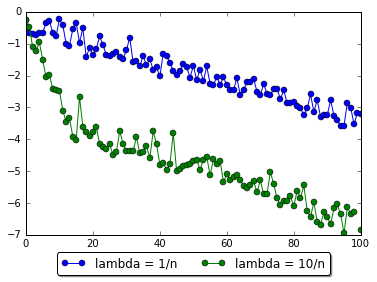

In [7]:
n = 32561; 
d = 123; 
import readsvm 
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
# X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
passes = 100
alpha = run_small_experiment(X,y, lambd,passes,"plot/a9a_ridge_dual.eps",primal_accuracy =True)

primal obj=0.448450687754


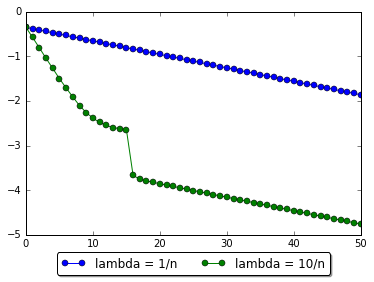

In [10]:
n = 32561; 
d = 123; 
import readsvm 

filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
# X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/float(n)
passes = 50
alpha = run_small_experiment(X,y, lambd,passes,"plot/a9a_dual_sdca.eps",primal_accuracy =False)

primal obj=0.45076673682
 Initial objective value: 0.45076673682
Obj[0]= 0.130165283058
Obj[1]= 0.0132777953455
Obj[2]= 0.00679908719638
Obj[3]= 0.0133252424417
Obj[4]= 0.022632946533
Obj[5]= 0.0340870749246
Obj[6]= 0.0475857279758
Obj[7]= 0.0628641330084
Obj[8]= 0.0798998001128
Obj[9]= 0.0986319428904
Obj[10]= 0.118857717826
Obj[11]= 0.140682605927
Obj[12]= 0.163919299016
Obj[13]= 0.188553413281
Obj[14]= 0.214511162865
Obj[15]= 0.241569242581
Obj[16]= 0.270152117231
Obj[17]= 0.299679634522
Obj[18]= 0.330498665245
Obj[19]= 0.362255608059


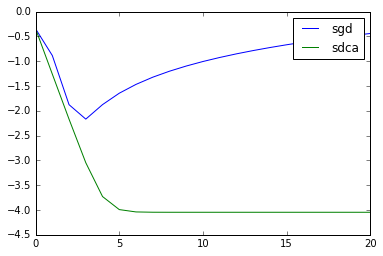

In [15]:
n = 32561; 
d = 123; 
primal_accuracy = False
epochs = int(20)

filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
lambd = 100.0/float(n)
clf = Ridge(alpha=lambd*n,fit_intercept=False)
clf.fit(X, y)
primal_opt =  primal_func(clf.coef_,0,X,y,lambd)
print("primal obj={}".format(primal_opt))
def dist_opt(w,alpha,X2,y2,lambd2):
  if primal_accuracy == True: 
    return primal_func(w,alpha,X2,y2,lambd) - primal_opt
  return primal_opt - dual_obj(w, alpha,X2,y2,lambd)
alpha,stat_sgd,w = sgd_for_sdca_rigde(X,y,lambd,epochs,obj = dist_opt, verbose = True)
alpha,stat_sdca,w = dual_rigde(X,y, lambd, epochs,n,obj = dist_opt, verbose = False)
t_sgd,err_sgd = get_data_plot(stat_sgd)
t_sdca,err_sdca = get_data_plot(stat_sdca)
plt.plot(t_sgd,np.log10(err_sgd),label='sgd')
plt.plot(t_sdca,np.log10(err_sdca),label='sdca')
plt.legend()

primal obj=0.355197469316


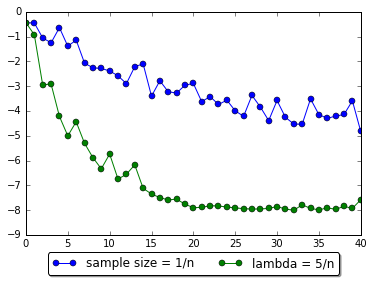

In [21]:
n = 49749; 
d = 300; 
filename = "../datasets/w8a"
y, X = readfile(filename,n,d)
A = np.zeros((n,d))
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
    A[i,:] = y[i]*X[i,:]
lambd = 1.0/n
passes = 40
run_small_experiment(X,y,lambd,passes,"plot/w8a_ridge_primal.eps",primal_accuracy = True)

primal obj=0.355197469316


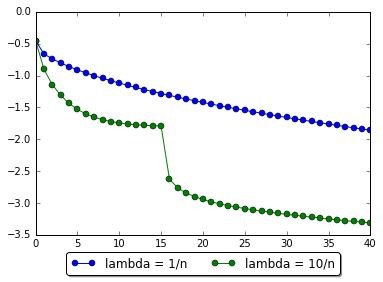

In [11]:
n = 49749; 
d = 300; 
filename = "../datasets/w8a"
y, X = readfile(filename,n,d)
# X = preprocessing.normalize(X, norm='l2')
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
lambd = 1.0/n
passes = 40
run_small_experiment(X,y,lambd,passes,"plot/w8a_dual_sdca.eps",primal_accuracy = False)

primal obj=0.48001585772


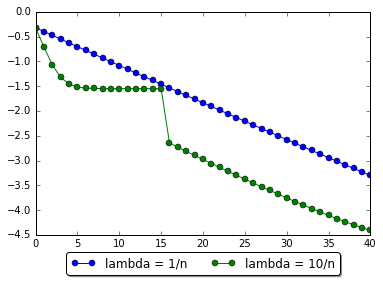

In [12]:
n = 50100; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
y, X = readfile(filename,n,d)
for i in range(n):
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
lambd = 1.0/n
passes = 40
run_small_experiment(X,y,lambd,passes,"plot/covtype_dual_sdca.eps",primal_accuracy = False)

In [28]:
def distance_plot(X,y,n,d,lambd,nr,pivotsi,verbose = True):
    print(max(np.linalg.norm(X,axis =1 )))
    if(verbose):
        print("Loading Data Accomblished")
    indices = np.random.choice(n, pivotsi, replace=False)
    X = X[indices,:]
    y = y[indices]
    t1,t2 = X.shape
    print('t1:{},t2:{}'.format(t1,t2))
    for i in range(len(y)): 
        if y[i] == 2 :
            y[i] = -1
    n = pivotsi
    x0 = np.zeros(d)
    csize = 256
    sizes = [csize]
    while csize < (n/4.0):
        csize = 2* csize
        sizes.append(csize)
 
    clf = Ridge(alpha=lambd*n,fit_intercept=False) 
    pivot = clf.fit(X, y).coef_
    pivot_primal = primal_func(pivot,0,X,y,lambd)
    print("precision:{},pivot_norm:{}".format(primal_func(pivot,0,X,y,lambd),(np.linalg.norm(pivot))))
    spivot = str(pivot)[2:-2]
    
    dists= np.zeros((len(sizes),nr))
    angles = np.zeros((len(sizes),nr))
    for i in range(len(sizes)):
        subsamplsi = sizes[i]
        for j in range(nr):
#             print('subsample size:{}'.format(subsamplsi))
            subindices = np.random.choice(n, subsamplsi, replace=False)
            lambd_s = 1.0/subsamplsi
            clf2 = Ridge(alpha=lambd_s*n,fit_intercept=False)
            clf2.fit(X, y)
            ws = clf2.coef_
            dist = primal_func(ws,0,X,y,lambd_s) - pivot_primal
            print("======================")
            print('mu={},nu={}'.format(lambd_s,lambd))
            print('norm(wmu-wv) = {}'.format(np.linalg.norm(pivot-ws)))
            print('norm(wmu)={},norm(wv)={}'.format(np.linalg.norm(ws),np.linalg.norm(pivot)))
            dists[i,j] = abs(dist)
            print("f_mu - fv= {}".format(dists[i,j]))
        if(verbose):
          print("step: {}".format(i))   
    mdist = np.mean(dists,axis=1)
    vdist = np.var(np.log(dists),axis =1)
    print(vdist)
    sizes = np.divide(1.0,sizes)
    xd = np.log(sizes)
    yd = np.log(mdist)
    par = np.polyfit(xd, yd, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]
    mang = np.mean(angles,axis = 1)
    vang = np.var(angles,axis= 1)
    plt.errorbar(np.log(sizes),np.log(mdist),yerr=vdist)
    #plt.plot(np.log(sizes),np.log(mdist),marker='o')
    label_l = "y =%.2f x + %.2f" % (slope,intercept)
    print(label_l)
    plt.plot(xl,yl,label = label_l)
    plt.xlabel("Log(m)")
    plt.ylabel("Log(|P_m^* - P_n^*|)")
   # plt.title("Distance Plot For %s" % dataname)
    plt.legend()

10.677078252
Loading Data Accomblished
t1:49749,t2:300
precision:0.355197469316,pivot_norm:5.13170178348
mu=0.00390625,nu=2.01009065509e-05
norm(wmu-wv) = 4.21579342637
norm(wmu)=1.54606598498,norm(wv)=5.13170178348
f_mu - fv= 0.0168761820847
step: 0
mu=0.001953125,nu=2.01009065509e-05
norm(wmu-wv) = 3.76636395165
norm(wmu)=1.96409710474,norm(wv)=5.13170178348
f_mu - fv= 0.0119679260088
step: 1
mu=0.0009765625,nu=2.01009065509e-05
norm(wmu-wv) = 3.1856134041
norm(wmu)=2.50596451445,norm(wv)=5.13170178348
f_mu - fv= 0.00794231074247
step: 2
mu=0.00048828125,nu=2.01009065509e-05
norm(wmu-wv) = 2.52665574095
norm(wmu)=3.12797504459,norm(wv)=5.13170178348
f_mu - fv= 0.00483652282827
step: 3
mu=0.000244140625,nu=2.01009065509e-05
norm(wmu-wv) = 1.87363813603
norm(wmu)=3.74081446209,norm(wv)=5.13170178348
f_mu - fv= 0.00268075304756
step: 4
mu=0.0001220703125,nu=2.01009065509e-05
norm(wmu-wv) = 1.28084450665
norm(wmu)=4.26419388488,norm(wv)=5.13170178348
f_mu - fv= 0.00134092746848
step: 5
m

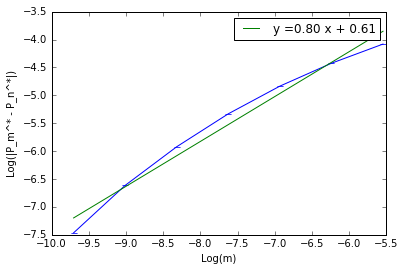

In [29]:
n = 49749; 
d = 300; 
filename = "../datasets/w8a"
y, X = readfile(filename,n,d)
#X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
distance_plot(X,y,n,d,lambd,1,n)

3.74165738677
Loading Data Accomblished
t1:32561,t2:123
precision:0.448450687754,pivot_norm:1.40628656539
mu=0.00390625,nu=3.0711587482e-05
norm(wmu-wv) = 0.715350430069
norm(wmu)=1.03966172346,norm(wv)=1.40628656539
f_mu - fv= 0.00285437647442
step: 0
mu=0.001953125,nu=3.0711587482e-05
norm(wmu-wv) = 0.607532929037
norm(wmu)=1.10104278513,norm(wv)=1.40628656539
f_mu - fv= 0.00155789736638
step: 1
mu=0.0009765625,nu=3.0711587482e-05
norm(wmu-wv) = 0.480726780024
norm(wmu)=1.1641858363,norm(wv)=1.40628656539
f_mu - fv= 0.000835541074375
step: 2
mu=0.00048828125,nu=3.0711587482e-05
norm(wmu-wv) = 0.34431942684
norm(wmu)=1.23011952016,norm(wv)=1.40628656539
f_mu - fv= 0.000432462650813
step: 3
mu=0.000244140625,nu=3.0711587482e-05
norm(wmu-wv) = 0.216309186095
norm(wmu)=1.29356054369,norm(wv)=1.40628656539
f_mu - fv= 0.000210723396293
step: 4
mu=0.0001220703125,nu=3.0711587482e-05
norm(wmu-wv) = 0.113988122471
norm(wmu)=1.34618547197,norm(wv)=1.40628656539
f_mu - fv= 9.22841525765e-05
ste

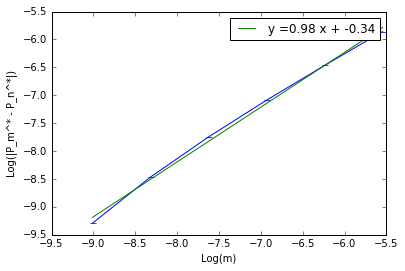

In [31]:
n = 32561; 
d = 123;
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
#X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
distance_plot(X,y,n,d,lambd,1,n)

2.74779987078
Loading Data Accomblished
t1:50100,t2:54
precision:0.48001585772,pivot_norm:41.6857160432
mu=0.00390625,nu=1.99600798403e-05
norm(wmu-wv) = 4.59623534583
norm(wmu)=2.59330842209,norm(wv)=6.45644763343
f_mu - fv= 0.0403006214755
step: 0
mu=0.001953125,nu=1.99600798403e-05
norm(wmu-wv) = 3.81644481642
norm(wmu)=3.28725874154,norm(wv)=6.45644763343
f_mu - fv= 0.0265223458843
step: 1
mu=0.0009765625,nu=1.99600798403e-05
norm(wmu-wv) = 2.97466005977
norm(wmu)=4.0852794441,norm(wv)=6.45644763343
f_mu - fv= 0.0159554943098
step: 2
mu=0.00048828125,nu=1.99600798403e-05
norm(wmu-wv) = 2.22974864349
norm(wmu)=4.8413387952,norm(wv)=6.45644763343
f_mu - fv= 0.00877906430799
step: 3
mu=0.000244140625,nu=1.99600798403e-05
norm(wmu-wv) = 1.66623696719
norm(wmu)=5.43778595844,norm(wv)=6.45644763343
f_mu - fv= 0.00448228209424
step: 4
mu=0.0001220703125,nu=1.99600798403e-05
norm(wmu-wv) = 1.23713579299
norm(wmu)=5.8513898385,norm(wv)=6.45644763343
f_mu - fv= 0.0021244498608
step: 5
mu=6.1

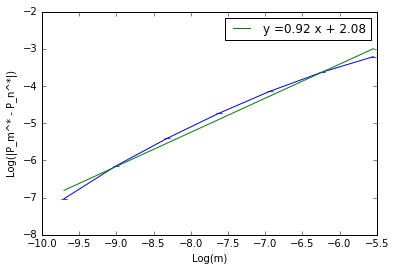

In [27]:
n = 50100; 
d = 54; 
filename = "../datasets/covtype.libsvm.binary.scale"
y, X = readfile(filename,n,d)
lambd = 1.0/n
distance_plot(X,y,n,d,lambd,1,n)

In [66]:
n = 32561; 
d = 123;
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
#X = preprocessing.normalize(X, norm='l2')
lambd = 1.0/n
U, s, V = np.linalg.svd(X, full_matrices=False)
s2 = np.power(s,2)
s = s/float(n)
s2 = s2/float(n)
s2l = s2 + lambd
d = np.divide(s,s2l)
w = np.dot(np.transpose(V),np.dot(np.diag(d),np.dot(np.transpose(U),y)))

In [102]:
d

array([  2.21005885e-03,   5.77273172e-03,   7.25896438e-03,
         8.22563297e-03,   8.84888002e-03,   9.48748192e-03,
         1.04069118e-02,   1.10293133e-02,   1.14033076e-02,
         1.21731248e-02,   1.22863182e-02,   1.23419303e-02,
         1.23907330e-02,   1.24596644e-02,   1.25735766e-02,
         1.30615699e-02,   1.33295501e-02,   1.43354811e-02,
         1.46188232e-02,   1.48751607e-02,   1.56654303e-02,
         1.56935787e-02,   1.64823874e-02,   1.68441256e-02,
         1.71645854e-02,   1.76399082e-02,   1.81015801e-02,
         1.87389395e-02,   1.88909020e-02,   1.99162828e-02,
         2.08795157e-02,   2.11754696e-02,   2.13628122e-02,
         2.24771786e-02,   2.32668181e-02,   2.36415469e-02,
         2.46533153e-02,   2.55289201e-02,   2.64419009e-02,
         2.69419683e-02,   2.87810074e-02,   2.90023400e-02,
         2.93978468e-02,   3.02650551e-02,   3.08210055e-02,
         3.12605257e-02,   3.19048894e-02,   3.25834162e-02,
         3.42062673e-02,

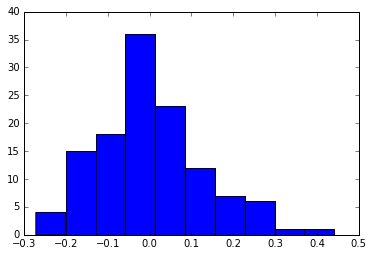

In [61]:
d = np.divide(s,s2l)
p = np.dot(np.diag(d),np.dot(np.transpose(U),y))
plt.hist(p)
plt.savefig('histogram3.eps', facecolor='w', edgecolor='w', orientation='portrait',  format='eps')

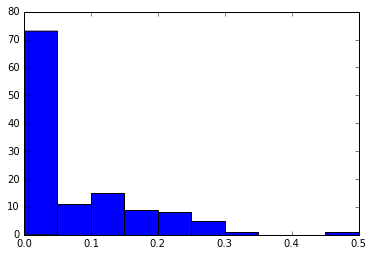

In [44]:
plt.hist(d)
plt.savefig('histogram2.eps', facecolor='w', edgecolor='w', orientation='portrait',  format='eps')

In [96]:
d

array([  2.21005885e-03,   5.77273172e-03,   7.25896438e-03,
         8.22563297e-03,   8.84888002e-03,   9.48748192e-03,
         1.04069118e-02,   1.10293133e-02,   1.14033076e-02,
         1.21731248e-02,   1.22863182e-02,   1.23419303e-02,
         1.23907330e-02,   1.24596644e-02,   1.25735766e-02,
         1.30615699e-02,   1.33295501e-02,   1.43354811e-02,
         1.46188232e-02,   1.48751607e-02,   1.56654303e-02,
         1.56935787e-02,   1.64823874e-02,   1.68441256e-02,
         1.71645854e-02,   1.76399082e-02,   1.81015801e-02,
         1.87389395e-02,   1.88909020e-02,   1.99162828e-02,
         2.08795157e-02,   2.11754696e-02,   2.13628122e-02,
         2.24771786e-02,   2.32668181e-02,   2.36415469e-02,
         2.46533153e-02,   2.55289201e-02,   2.64419009e-02,
         2.69419683e-02,   2.87810074e-02,   2.90023400e-02,
         2.93978468e-02,   3.02650551e-02,   3.08210055e-02,
         3.12605257e-02,   3.19048894e-02,   3.25834162e-02,
         3.42062673e-02,

(array([ 73.,  11.,  15.,   9.,   8.,   5.,   1.,   0.,   0.,   1.]),
 array([  1.06082143e-13,   4.99998561e-02,   9.99997122e-02,
          1.49999568e-01,   1.99999424e-01,   2.49999280e-01,
          2.99999136e-01,   3.49998993e-01,   3.99998849e-01,
          4.49998705e-01,   4.99998561e-01]),
 <a list of 10 Patch objects>)

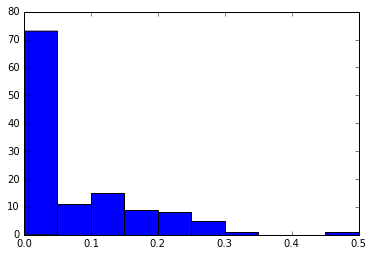

In [40]:
plt.hist(d)

In [38]:
np.linalg.norm(w)

1.4062865653923524

In [39]:
w.shape

(123,)

In [45]:
U.shape

(32561, 123)

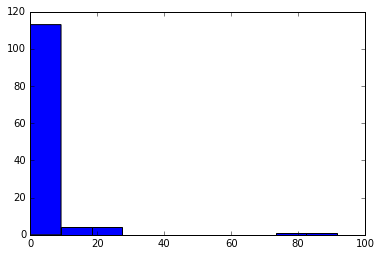

In [59]:
a = np.zeros(123)
for i in range(123): 
    a[i] = np.linalg.norm(np.multiply(V[:,i],np.dot(U[:,i],y)))
plt.hist(a)
plt.savefig('histogram2.eps', facecolor='w', edgecolor='w', orientation='portrait',  format='eps')

In [47]:
U[:,i]

array([-0.00484203, -0.00565247, -0.00619019, ..., -0.00569119,
       -0.00604209, -0.00470896])

In [48]:
y

array([-1., -1., -1., ..., -1., -1.,  1.])

In [50]:
V.shape

(123, 123)

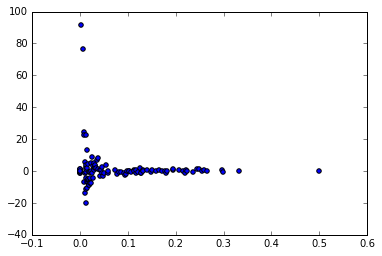

In [103]:
tem = np.dot(np.transpose(U),y)
plt.scatter(d,tem)
plt.savefig('dot_vs_eign.eps', facecolor='w', edgecolor='w', orientation='portrait',  format='eps')

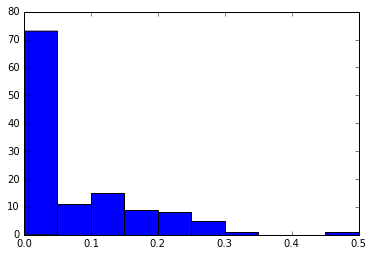

In [72]:
d
plt.hist(d)
plt.savefig('histogram4.eps', facecolor='w', edgecolor='w', orientation='portrait',  format='eps')

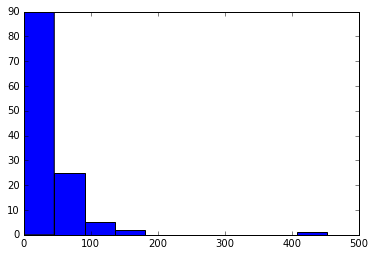

In [81]:
plt.hist(s*n)
plt.savefig('histogram5.eps', facecolor='w', edgecolor='w', orientation='portrait',  format='eps')

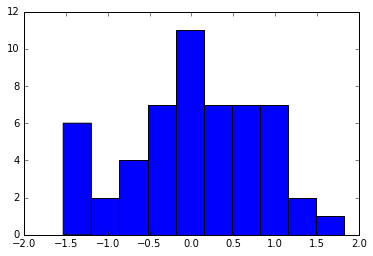

In [94]:
inds = s*n < 10 
t = np.dot(np.transpose(U[:,inds]),y)
plt.hist(t)
plt.savefig('histogram_dots_for_small_lambad.eps', facecolor='w', edgecolor='w', orientation='portrait',  format='eps')

In [92]:
sum(inds)

54

array([  4.52474429e+02,   1.73222440e+02,   1.37753439e+02,
         1.21562965e+02,   1.12999802e+02,   1.05392557e+02,
         9.60795772e+01,   9.06564456e+01,   8.76824502e+01,
         8.21360014e+01,   8.13790595e+01,   8.10122593e+01,
         8.06930827e+01,   8.02465218e+01,   7.95192894e+01,
         7.65474113e+01,   7.50079550e+01,   6.97426507e+01,
         6.83903371e+01,   6.72112860e+01,   6.38191557e+01,
         6.37046316e+01,   6.06543357e+01,   5.93510295e+01,
         5.82423209e+01,   5.66719919e+01,   5.52256886e+01,
         5.33460674e+01,   5.29166372e+01,   5.01902486e+01,
         4.78729424e+01,   4.72032694e+01,   4.67889439e+01,
         4.44670811e+01,   4.29563834e+01,   4.22747618e+01,
         4.05378275e+01,   3.91457157e+01,   3.77923032e+01,
         3.70898515e+01,   3.47163306e+01,   3.44509497e+01,
         3.39866734e+01,   3.30111141e+01,   3.24145545e+01,
         3.19579342e+01,   3.13112209e+01,   3.06578410e+01,
         2.92001624e+01,

In [ ]:
np.transpose(U)